In [0]:
import keras
import numpy as np
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.layers import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [0]:
from google.colab import files
uploaded = files.upload()

Saving bank.csv to bank.csv


# Read the dataset

In [0]:
dfbank = pd.read_csv("bank.csv")
print('- Data shape : {} \n '.format(dfbank.shape))
print( "- Columns : {} \n".format(dfbank.keys()))
# Checking for missing values
print('- Number of missing values :', dfbank.isnull().any().sum())
dfbank.sample(5)

- Data shape : (10000, 14) 
 
- Columns : Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object') 

- Number of missing values : 0


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6082,6083,15636820,Loggia,725,Germany,Male,40,8,104149.66,1,1,0,62027.90,0
1804,1805,15605263,Chin,552,France,Male,33,5,140931.57,1,0,1,10921.50,0
2261,2262,15681402,Ngozichukwuka,763,Germany,Female,61,1,66101.89,1,1,1,143981.27,0
6947,6948,15809558,Peppin,715,Spain,Male,31,7,0.00,1,1,1,149970.59,0
4368,4369,15621116,Fang,648,Germany,Male,33,5,138664.24,1,1,0,29076.27,0


In [0]:
dfbank.info()
dfbank.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


# Drop the columns which are unique for all users like IDs

In [0]:
# Removing these features('RowNumber','CustomerId','Surname') as these features do not effect with the model prediction
dfbank.drop(['CustomerId','Surname','RowNumber'], axis = 1, inplace=True)
dfbank.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Distinguish the feature and target set

Number of people who left : 2037 | Percentage : 20.37 %
Number of people who stayed : 7963 | Percentage : 79.63 %


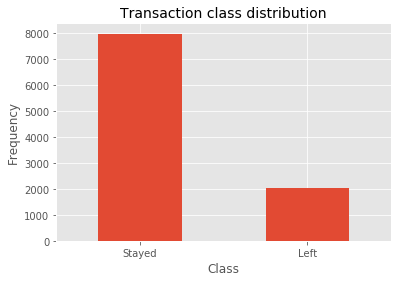

In [0]:
num_samples = dfbank.shape[0]
classes = pd.value_counts(dfbank['Exited'], sort = True)
num_stayers, num_leavers = classes[0], classes[1]

print('Number of people who left : {} | Percentage : {} %'.format(num_leavers, 100 * num_leavers / num_samples))
print('Number of people who stayed : {} | Percentage : {} %'.format(num_stayers, 100 * num_stayers / num_samples))

# Plotting the transaction class 
labels = ['Stayed','Left']
plt.style.use('ggplot')
classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution", {"fontsize" : 14})
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

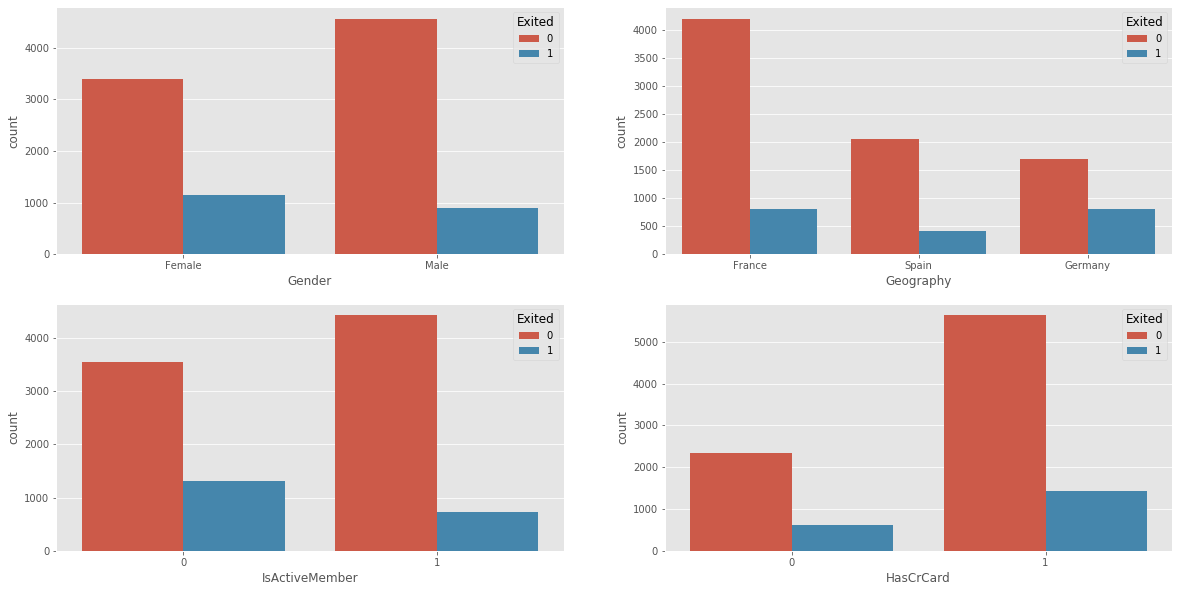

In [0]:
#set the figsize and number of subplts
fig, axarr = plt.subplots(2, 2, figsize=(20, 10))

#Relation between Gender and Exited
sns.countplot('Gender', hue = 'Exited',data = dfbank, ax = axarr[0][0])

#Relation between Geography and Exited
sns.countplot('Geography', hue = 'Exited', data = dfbank , ax = axarr[0][1])

#Relation between IsActiveMember and Exited
sns.countplot('IsActiveMember', hue = 'Exited', data = dfbank , ax = axarr[1][0])

#Relation between HasCrCard and Exited
sns.countplot('HasCrCard', hue = 'Exited', data = dfbank , ax = axarr[1][1])

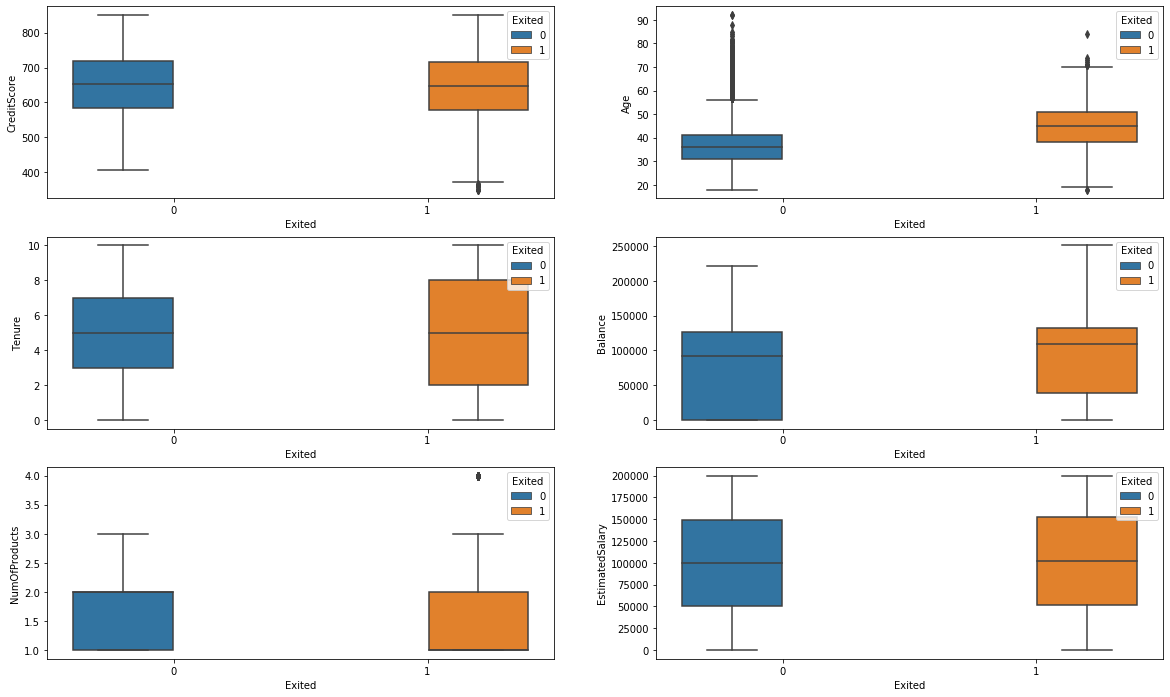

In [0]:
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = dfbank, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = dfbank , ax=axarr[0][1])
sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = dfbank, ax=axarr[1][0])
sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = dfbank, ax=axarr[1][1])
sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = dfbank, ax=axarr[2][0])
sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = dfbank, ax=axarr[2][1])

**Inferences**
* The proportion of female customers churning is also greater than that of male customers
* Majority of the customers that churned are those with credit cards
* Inactive members have a greater churn as compared to active members
* The older customers are churning at more than the younger
* With regard to the tenure, the clients on either extreme end (spent little time with the bank or a lot of time with the bank) are more likely to churn compared to those that are of average tenure
* The bank is losing customers with significant bank balances
* Neither the product nor the salary has a significant effect on the likelihood to churn


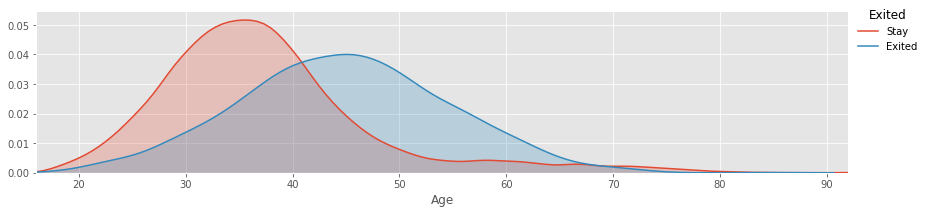

In [0]:
FacetGrid = sns.FacetGrid(dfbank, hue='Exited', aspect=4)
FacetGrid.map(sns.kdeplot, 'Age', shade=True )
FacetGrid.set(xlim=(16, dfbank['Age'].max()))
FacetGrid.add_legend(labels = ['Stay', "Exited"])

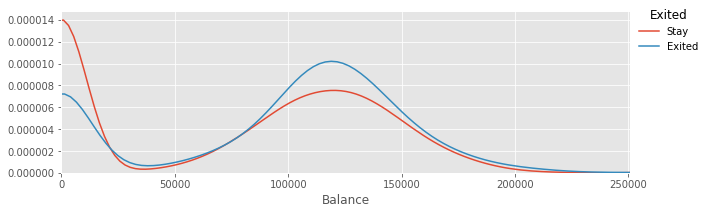

In [0]:
FacetGrid = sns.FacetGrid(dfbank, hue='Exited', aspect=3)
FacetGrid.map(sns.kdeplot, 'Balance', shade=False )
FacetGrid.set(xlim=(dfbank['Balance'].min(), dfbank['Balance'].max()))
FacetGrid.add_legend(labels = ['Stay', "Exited"])

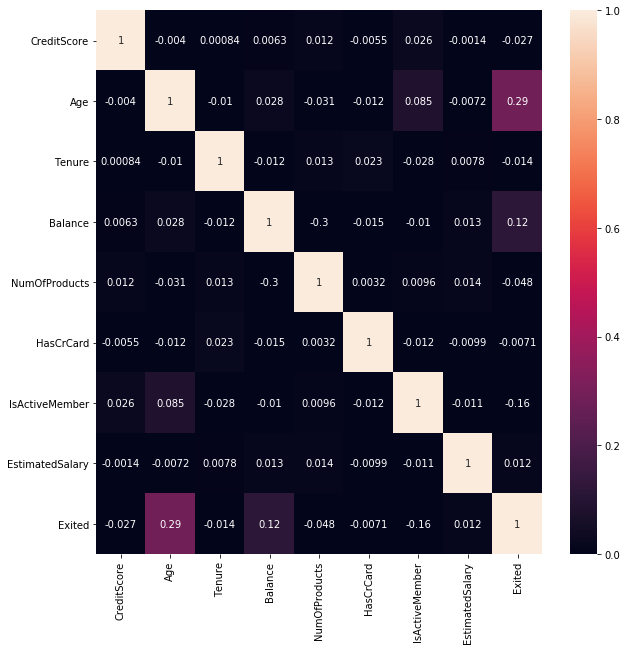

In [0]:
#Correlation between the numerical feature
corr = dfbank.corr()
#set figure size 
plt.subplots(figsize=(10, 10))
#plot the 
ax = sns.heatmap(corr, vmin=0, vmax=1, annot=True)
plt.show()

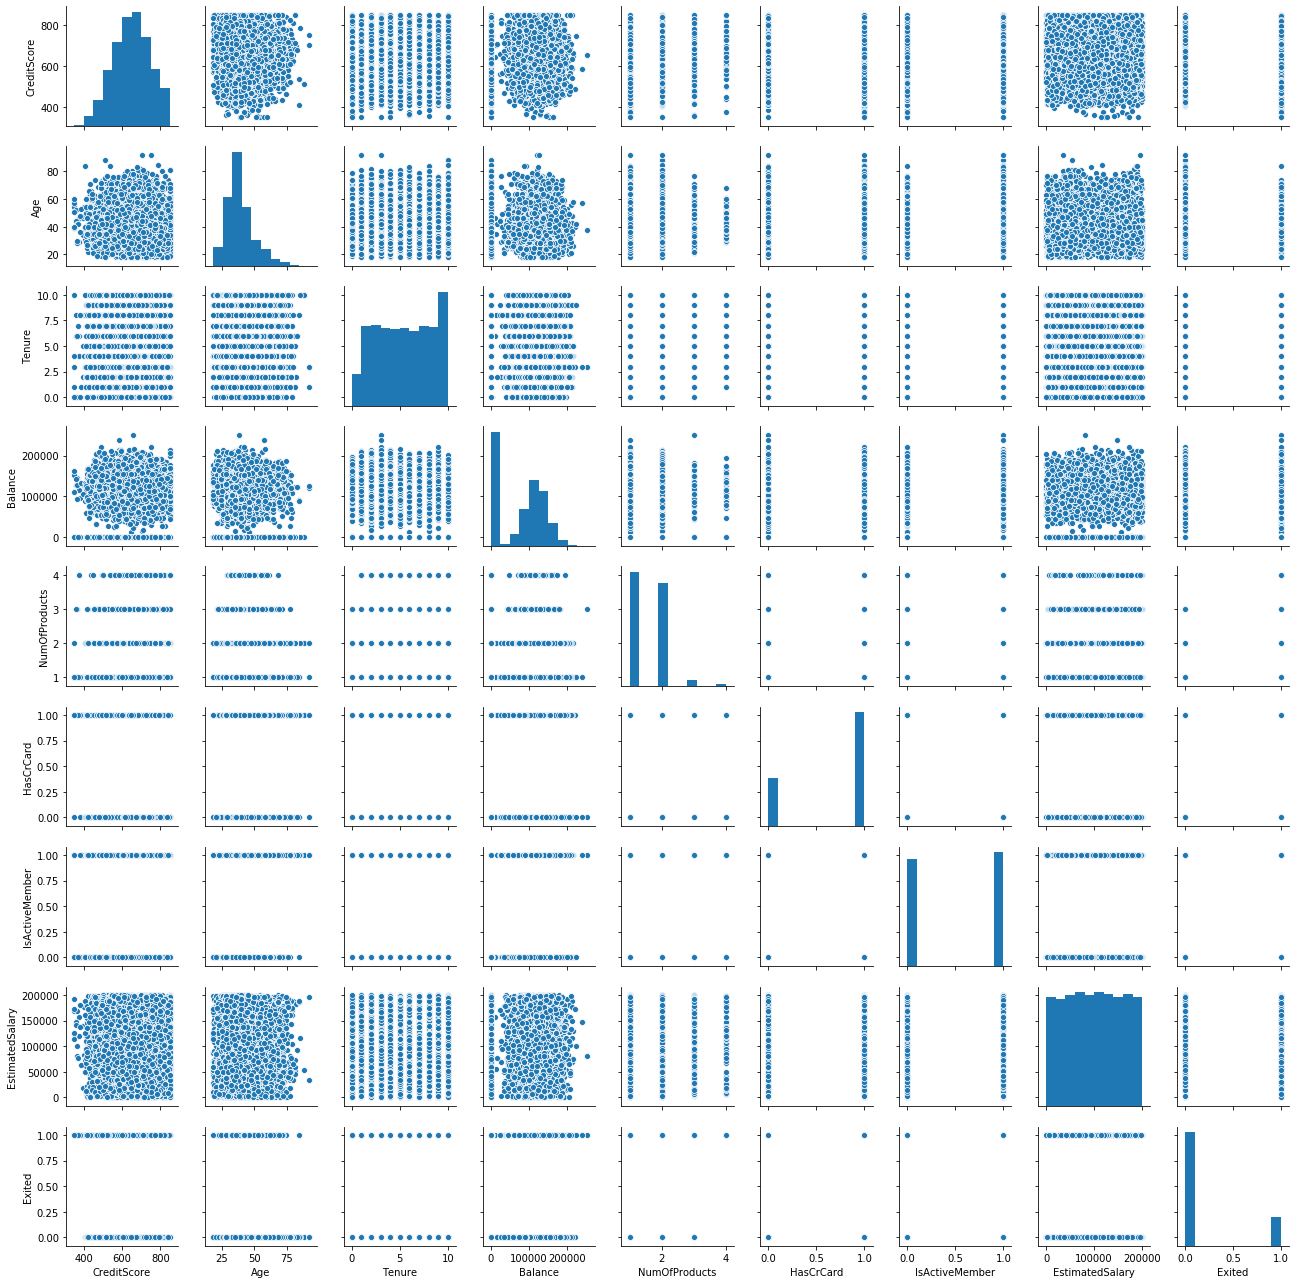

In [0]:
sn.pairplot(data = dfbank, size = 2)

There is no correlation between features and target

# Divide the data set into Train and test sets

In [0]:
y=dfbank[['Exited']]
X= dfbank.drop('Exited', axis=1)
dummies = pd.get_dummies(X[['Geography', 'Gender']])
X = X.drop(columns = ['Geography', 'Gender'])
X = pd.concat([X, dummies], axis = 1)

X.rename(columns={'Gender_Female':'Female',
                  'Gender_Male':'Male',
                  'Geography_France': 'France',
                  'Geography_Germany' : 'Germany',
                  'Geography_Spain':'Spain'}, inplace = True)

display(X.head())
display(y.head())

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain,Female,Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,1,0


,Exited
0,1
1,0
2,1
3,0
4,0


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print('X_train.shape() = {}'.format(X_train.shape))
print('Y_train.shape() = {}'.format(y_train.shape))
print('X_test.shape() = {}'.format(X_test.shape))
print('Y_test.shape() = {}'.format(y_test.shape))

X_train.shape() = (8000, 13)
Y_train.shape() = (8000, 1)
X_test.shape() = (2000, 13)
Y_test.shape() = (2000, 1)


# Normalize the train and test data

In [0]:
# Feature Scaling
# As we can see from the data, there are difference in scale of data in each catagory in the set.
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Initialize & build the model

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

batch_size = 10
epochs = 100

model = Sequential()
model.add(Dense(7,kernel_initializer='uniform',activation='relu', input_dim=13))
model.add(Dropout(p=0.1))
model.add(Dense(7,kernel_initializer='uniform',activation='relu'))
model.add(Dropout(p=0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='rmsprop', metrics=['accuracy'])
model.summary()
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test), callbacks=[es])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 7)                 98        
_________________________________________________________________
dropout_5 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 56        
_________________________________________________________________
dropout_6 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 8         
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 5s 577us/step - l

# Optimize the model

In [0]:
from sklearn.model_selection import GridSearchCV
def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(7,kernel_initializer='uniform',activation='relu', input_dim=13))
    classifier.add(Dropout(p=0.1))
    classifier.add(Dense(7,kernel_initializer='uniform',activation='relu'))
    classifier.add(Dropout(p=0.1))
    classifier.add(Dense(1, activation='sigmoid'))
    classifier.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    return classifier

es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

classifier = KerasClassifier(build_fn = build_classifier)

parameters = {'batch_size': [10, 50, 100],
              'epochs': [10, 50, 100]}

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 3)

grid_search = grid_search.fit(X_train, y_train,callbacks= [es])
# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/10
5333/5333 [==============================] - 4s 662us/step - loss: 0.4996 - acc: 0.7939
Epoch 2/10
5333/5333 [==============================] - 3s 571us/step - loss: 0.4432 - acc: 0.7943
Epoch 3/10
5333/5333 [==============================] - 3s 571us/step - loss: 0.4339 - acc: 0.7943
Epoch 4/10
5333/5333 [==============================] - 3s 575us/step - loss: 0.4292 - acc: 0.7943
Epoch 5/10
5333/5333 [==============================] - 3s 567us/step - loss: 0.4344 - acc: 0.7943
Epoch 6/10
5333/5333 [==============================] - 3s 562us/step - loss: 0.4294 - acc: 0.7943
Epoch 7/10
5333/5333 [==============================] - 3s 558us/step - loss: 0.4284 - acc: 0.7943
Epoch 8/10
5333/5333 [==============================] - 3s 570us/step - loss: 0.4283 - acc: 0.8074
Epoch 9/10
5333/5333 [==============================] - 3s 565us/step - loss: 0.4245 - acc: 0.8183
Epoch 10/10
5333/5333 [==============================] - 3s 581us/step - loss: 0.4245 - acc: 0.8234
Epoch 1/1

We can see that the batch size of 100 and 50 epochs achieved the best result of about 83.5% accuracy.

In [0]:
from sklearn.model_selection import GridSearchCV
def build_classifier(optimizer='adam'):
    classifier = Sequential()
    classifier.add(Dense(7,kernel_initializer='uniform',activation='relu', input_dim=13))
    classifier.add(Dropout(p=0.1))
    classifier.add(Dense(7,kernel_initializer='uniform',activation='relu'))
    classifier.add(Dropout(p=0.1))
    classifier.add(Dense(1, activation='sigmoid'))
    classifier.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])
    return classifier

es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

classifier = KerasClassifier(build_fn = build_classifier,epochs=50, batch_size=100)

parameters = {'optimizer':["adagrad", "adam", "rmsprop", "adadelta"]}

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 3)

grid_search = grid_search.fit(X_train, y_train,callbacks= [es])

# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/50
5333/5333 [==============================] - 4s 690us/step - loss: 0.5532 - acc: 0.7920
Epoch 2/50
5333/5333 [==============================] - 0s 59us/step - loss: 0.4666 - acc: 0.7943
Epoch 3/50
5333/5333 [==============================] - 0s 53us/step - loss: 0.4555 - acc: 0.7943
Epoch 4/50
5333/5333 [==============================] - 0s 58us/step - loss: 0.4495 - acc: 0.7943
Epoch 5/50
5333/5333 [==============================] - 0s 67us/step - loss: 0.4486 - acc: 0.7943
Epoch 6/50
5333/5333 [==============================] - 0s 67us/step - loss: 0.4430 - acc: 0.7943
Epoch 7/50
5333/5333 [==============================] - 0s 73us/step - loss: 0.4432 - acc: 0.7943
Epoch 8/50
5333/5333 [==============================] - 0s 82us/step - loss: 0.4445 - acc: 0.7943
Epoch 9/50
5333/5333 [==============================] - 0s 76us/step - loss: 0.4406 - acc: 0.7943
Epoch 10/50
5333/5333 [==============================] - 0s 72us/step - loss: 0.4403 - acc: 0.7943
Epoch 11/50
5333/5

In [0]:
from google.colab import drive
drive.mount('/content/drive')

The results suggest that the adadelta optimization algorithm is the best with a score of about 84% accuracy.

In [0]:
from sklearn.model_selection import GridSearchCV
def build_classifier(activation='relu'):
    classifier = Sequential()
    classifier.add(Dense(7,kernel_initializer='uniform',activation=activation, input_dim=13))
    classifier.add(Dropout(p=0.1))
    classifier.add(Dense(7,kernel_initializer='uniform',activation=activation))
    classifier.add(Dropout(p=0.1))
    classifier.add(Dense(1, activation='sigmoid'))
    classifier.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adadelta(lr=1.0), metrics=['accuracy'])
    return classifier

es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

classifier = KerasClassifier(build_fn = build_classifier,epochs=50, batch_size=100)

parameters = {'activation':["relu", "tanh", "sigmoid"]}

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 3)

grid_search = grid_search.fit(X_train, y_train,callbacks= [es])

# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/50
5333/5333 [==============================] - 7s 1ms/step - loss: 0.6182 - acc: 0.7799
Epoch 2/50
5333/5333 [==============================] - 0s 66us/step - loss: 0.4527 - acc: 0.7943
Epoch 3/50
5333/5333 [==============================] - 0s 66us/step - loss: 0.4411 - acc: 0.7947
Epoch 4/50
5333/5333 [==============================] - 0s 64us/step - loss: 0.4368 - acc: 0.8140
Epoch 5/50
5333/5333 [==============================] - 0s 76us/step - loss: 0.4285 - acc: 0.8174
Epoch 6/50
5333/5333 [==============================] - 0s 65us/step - loss: 0.4220 - acc: 0.8217
Epoch 7/50
5333/5333 [==============================] - 0s 68us/step - loss: 0.4162 - acc: 0.8187
Epoch 8/50
5333/5333 [==============================] - 0s 75us/step - loss: 0.4150 - acc: 0.8204
Epoch 9/50
5333/5333 [==============================] - 0s 72us/step - loss: 0.4100 - acc: 0.8224
Epoch 10/50
5333/5333 [==============================] - 0s 65us/step - loss: 0.4096 - acc: 0.8224
Epoch 11/50
5333/533

The ‘tanh’ activation function achieved the best results with an accuracy of about 85%

In [0]:
from sklearn.model_selection import GridSearchCV
def build_classifier(dropout_rate=0.0):
    classifier = Sequential()
    classifier.add(Dense(7,kernel_initializer='uniform',activation='tanh', input_dim=13))
    classifier.add(Dropout(p=dropout_rate))
    classifier.add(Dense(7,kernel_initializer='uniform',activation='tanh'))
    classifier.add(Dropout(p=dropout_rate))
    classifier.add(Dense(1, activation='sigmoid'))
    classifier.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adadelta(lr=1.0), metrics=['accuracy'])
    return classifier

es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

classifier = KerasClassifier(build_fn = build_classifier,epochs=50, batch_size=100)

parameters = {'dropout_rate':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 3)

grid_search = grid_search.fit(X_train, y_train,callbacks= [es])

# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/50
5333/5333 [==============================] - 9s 2ms/step - loss: 0.5915 - acc: 0.7875
Epoch 2/50
5333/5333 [==============================] - 1s 99us/step - loss: 0.4390 - acc: 0.8072
Epoch 3/50
5333/5333 [==============================] - 1s 99us/step - loss: 0.4381 - acc: 0.8146
Epoch 4/50
5333/5333 [==============================] - 1s 102us/step - loss: 0.4354 - acc: 0.8106
Epoch 5/50
5333/5333 [==============================] - 1s 102us/step - loss: 0.4340 - acc: 0.8134
Epoch 6/50
5333/5333 [==============================] - 1s 100us/step - loss: 0.4291 - acc: 0.8121
Epoch 7/50
5333/5333 [==============================] - 1s 96us/step - loss: 0.4240 - acc: 0.8147
Epoch 8/50
5333/5333 [==============================] - 1s 100us/step - loss: 0.4193 - acc: 0.8172
Epoch 9/50
5333/5333 [==============================] - 1s 98us/step - loss: 0.4171 - acc: 0.8206
Epoch 10/50
5333/5333 [==============================] - 1s 98us/step - loss: 0.4118 - acc: 0.8217
Epoch 11/50
5333

We can see that the dropout rate of 10% resulted in the best accuracy of about 85.16%.

**Using all the parameters and doing an 5 fold validation**

In [0]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
cvscores = []
for train, test in kfold.split(X = X_train, y = y_train):
    model = Sequential()
    model.add(Dense(7,kernel_initializer='uniform',activation='tanh', input_dim=13))
    model.add(BatchNormalization())
    model.add(Dropout(p=0.1))
    model.add(Dense(7,kernel_initializer='uniform',activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(p=0.1))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adadelta(lr=1.0), metrics=['accuracy'])
    model_history = model.fit(X_train, y_train,batch_size=100,epochs=50,verbose=1,validation_data=(X_test, y_test), callbacks=[es])
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 14s 2ms/step - loss: 0.6239 - acc: 0.6721 - val_loss: 0.5089 - val_acc: 0.7880
Epoch 2/50
8000/8000 [==============================] - 1s 113us/step - loss: 0.5352 - acc: 0.7519 - val_loss: 0.4588 - val_acc: 0.8055
Epoch 3/50
8000/8000 [==============================] - 1s 118us/step - loss: 0.4890 - acc: 0.7842 - val_loss: 0.4440 - val_acc: 0.8120
Epoch 4/50
8000/8000 [==============================] - 1s 121us/step - loss: 0.4649 - acc: 0.7941 - val_loss: 0.4376 - val_acc: 0.8170
Epoch 5/50
8000/8000 [==============================] - 1s 117us/step - loss: 0.4504 - acc: 0.8000 - val_loss: 0.4423 - val_acc: 0.8075
Epoch 6/50
8000/8000 [==============================] - 1s 118us/step - loss: 0.4482 - acc: 0.8025 - val_loss: 0.4343 - val_acc: 0.8165
Epoch 7/50
8000/8000 [==============================] - 1s 117us/step - loss: 0.4470 - acc: 0.8032 - val_loss: 0.4301 - val_acc: 0.8155
E

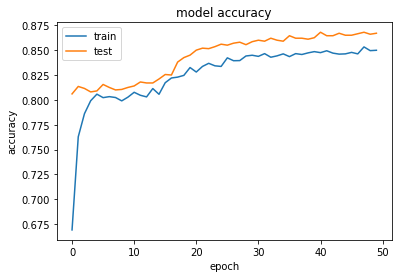

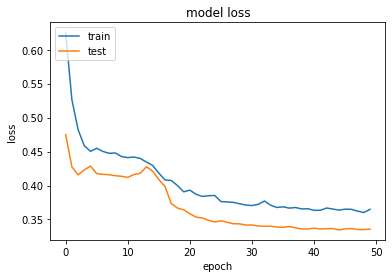

In [0]:
# summarize history for accuracy
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

So, we can see the accuracy on testing data is more than train data.

# Predict the results using 0.5 as a threshold

In [0]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
#let's try to predict if this customer will leave the bank or not, using our model:
#Geography: France
#Credit Score: 600
#Gender: Male
#Age: 40 years old
#Tenure: 3 years
#Balance: $60000
#Number of Products: 2
#Does this customer have a credit card ? Yes
#Is this customer an Active Member: Yes
#Estimated Salary: $50000
new_prediction = model.predict(sc.transform(np.array([[600, 40, 3, 60000, 2, 1, 1, 50000, 1, 0, 0, 0, 1 ]])))
new_prediction = (new_prediction>0.5)
print(new_prediction)
#false=meaning the customer will not leave the bank

[[False]]


# Print the Accuracy score and confusion matrix

Out of sample accuracy is 0.867
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1607
           1       0.74      0.50      0.60       393

    accuracy                           0.87      2000
   macro avg       0.81      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000



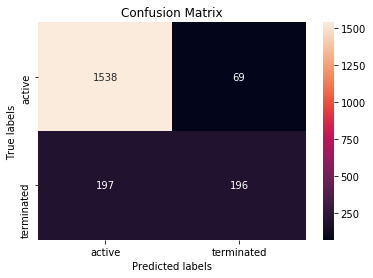

On test data 

accuracy:     0.87 
sensitivity:  0.5 
specifity:    0.96


In [0]:
# Find the accuracy rate
from sklearn.metrics import accuracy_score
print("Out of sample accuracy is", accuracy_score(y_test, y_pred, normalize=True))

from sklearn.metrics import classification_report, confusion_matrix, f1_score

def classification_metrics(actual, pred, msg):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    cm = confusion_matrix(actual, pred)

    plt.figure()
    ax= plt.subplot()
    sns.heatmap(cm, annot = True, fmt = 'g')

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['active', 'terminated']) 
    ax.yaxis.set_ticklabels(['active', 'terminated'])   
    plt.show()       
    sensitivity = cm[1][1]/(cm[1][0] + cm[1][1])
    specifity = cm[0][0]/(cm[0][0] + cm[0][1])
    accuracy = (cm[0][0] + cm[1][1]) / np.sum(cm)
    
    print(msg, '\n')
    print('accuracy:    ', round(accuracy,2), 
      '\nsensitivity: ', round(sensitivity,2), 
      '\nspecifity:   ', round(specifity,2))

report = classification_report(y_true = y_test, y_pred = y_pred)
print(report)
classification_metrics(actual = y_test, pred = y_pred, msg = "On test data")

In [0]:
# roc auc score - sensitivity vs specificity plot
# Area under curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.7278952927000354

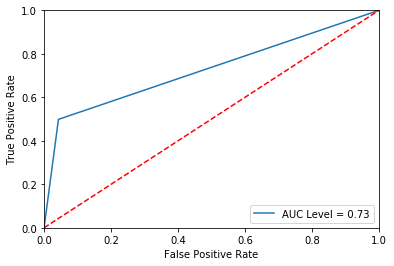

In [0]:
# Plotting roc curve

from sklearn import metrics

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate,label='AUC Level = %0.2f' % (roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()